In [1]:
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.config("spark.sql.legacy.timeParserPolicy", "LEGACY").master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [4]:
# Reading the csv file
data = spark.read.csv('nyc_taxi.csv', header=True, inferSchema=True)

In [6]:
data.collect()

[Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:00', distance=0.02, tip=0.0, fare=52.8),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:03', distance=0.5, tip=0.0, fare=5.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:39', distance=7.75, tip=4.66, fare=27.96),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:06', distance=0.8, tip=1.45, fare=8.75),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:08', distance=0.9, tip=0.0, fare=8.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:05', distance=1.76, tip=0.0, fare=8.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:15', distance=8.47, tip=7.71, fare=38.55),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_ti

In [5]:
data.printSchema()

root
 |-- pickup_date: string (nullable = true)
 |-- pickup_time: string (nullable = true)
 |-- dropoff_date: string (nullable = true)
 |-- dropoff_time: string (nullable = true)
 |-- distance: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- fare: double (nullable = true)



In [6]:
# converting the dataframe into an RDD
data_rdd=data.rdd

In [13]:
data_rdd.collect()

[Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:00', distance=0.02, tip=0.0, fare=52.8),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:03', distance=0.5, tip=0.0, fare=5.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:39', distance=7.75, tip=4.66, fare=27.96),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:06', distance=0.8, tip=1.45, fare=8.75),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:08', distance=0.9, tip=0.0, fare=8.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:05', distance=1.76, tip=0.0, fare=8.3),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_time='0:15', distance=8.47, tip=7.71, fare=38.55),
 Row(pickup_date='1/1/2017', pickup_time='0:00', dropoff_date='1/1/2017', dropoff_ti

In [7]:
# Using a function to concat the date and time column and calculating the duration of the trip by checking the difference between dropoff time and pickup time
# Converting the date to 12hr format and extracting the pickup hour for each ride


from datetime import datetime,timedelta
from pyspark.sql import Row

def calculate_time_difference(row):
    pickup_datetime = datetime.strptime(row['pickup_date'] + ' ' + row['pickup_time'], '%m/%d/%Y %H:%M')
    dropoff_datetime = datetime.strptime(row['dropoff_date'] + ' ' + row['dropoff_time'], '%m/%d/%Y %H:%M')
    time_difference = dropoff_datetime - pickup_datetime
    return Row(pickup_data = row['pickup_date'],pickup_hour=pickup_datetime.strftime('%I %p')
,dropoff_date=row['dropoff_date'],duration = (time_difference.total_seconds()/60),tip=row['tip'],distance = row['distance'],fare = row['fare'])

time_difference_rdd = data_rdd.map(calculate_time_difference)

In [9]:
time_difference_rdd.take(10)

[Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=0.0, tip=0.0, distance=0.02, fare=52.8),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=3.0, tip=0.0, distance=0.5, fare=5.3),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=39.0, tip=4.66, distance=7.75, fare=27.96),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=6.0, tip=1.45, distance=0.8, fare=8.75),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=8.0, tip=0.0, distance=0.9, fare=8.3),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=5.0, tip=0.0, distance=1.76, fare=8.3),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=15.0, tip=7.71, distance=8.47, fare=38.55),
 Row(pickup_data='1/1/2017', pickup_hour='12 AM', dropoff_date='1/1/2017', duration=11.0, tip=0.0, distance=2.4, fare=11.8),

In [8]:
# creating a data frame from RDD
time_diff_data = spark.createDataFrame(time_difference_rdd)

In [9]:
time_diff_data.show()

+-----------+-----------+------------+--------+----+--------+-----+
|pickup_data|pickup_hour|dropoff_date|duration| tip|distance| fare|
+-----------+-----------+------------+--------+----+--------+-----+
|   1/1/2017|      12 AM|    1/1/2017|     0.0| 0.0|    0.02| 52.8|
|   1/1/2017|      12 AM|    1/1/2017|     3.0| 0.0|     0.5|  5.3|
|   1/1/2017|      12 AM|    1/1/2017|    39.0|4.66|    7.75|27.96|
|   1/1/2017|      12 AM|    1/1/2017|     6.0|1.45|     0.8| 8.75|
|   1/1/2017|      12 AM|    1/1/2017|     8.0| 0.0|     0.9|  8.3|
|   1/1/2017|      12 AM|    1/1/2017|     5.0| 0.0|    1.76|  8.3|
|   1/1/2017|      12 AM|    1/1/2017|    15.0|7.71|    8.47|38.55|
|   1/1/2017|      12 AM|    1/1/2017|    11.0| 0.0|     2.4| 11.8|
|   1/1/2017|      12 AM|    1/1/2017|    23.0|10.0|    12.6| 70.3|
|   1/1/2017|      12 AM|    1/1/2017|     8.0|2.05|     0.9|10.35|
|   1/1/2017|      12 AM|    1/1/2017|     9.0| 2.7|    2.43| 13.5|
|   1/1/2017|      12 AM|    1/1/2017|    16.0|2

In [10]:
#Using vector assembler to convert the columns of interest into vectors to fit the model 

from pyspark.ml.feature import VectorAssembler

assembler_m1 = VectorAssembler(inputCols=["distance"], outputCol="features_m1")
data_m1 = assembler_m1.transform(time_diff_data)

assembler_m2 = VectorAssembler(inputCols=["distance","duration"], outputCol="features_m2")
data_m2 = assembler_m2.transform(time_diff_data)

In [11]:
data_m1.show()

+-----------+-----------+------------+--------+----+--------+-----+-----------+
|pickup_data|pickup_hour|dropoff_date|duration| tip|distance| fare|features_m1|
+-----------+-----------+------------+--------+----+--------+-----+-----------+
|   1/1/2017|      12 AM|    1/1/2017|     0.0| 0.0|    0.02| 52.8|     [0.02]|
|   1/1/2017|      12 AM|    1/1/2017|     3.0| 0.0|     0.5|  5.3|      [0.5]|
|   1/1/2017|      12 AM|    1/1/2017|    39.0|4.66|    7.75|27.96|     [7.75]|
|   1/1/2017|      12 AM|    1/1/2017|     6.0|1.45|     0.8| 8.75|      [0.8]|
|   1/1/2017|      12 AM|    1/1/2017|     8.0| 0.0|     0.9|  8.3|      [0.9]|
|   1/1/2017|      12 AM|    1/1/2017|     5.0| 0.0|    1.76|  8.3|     [1.76]|
|   1/1/2017|      12 AM|    1/1/2017|    15.0|7.71|    8.47|38.55|     [8.47]|
|   1/1/2017|      12 AM|    1/1/2017|    11.0| 0.0|     2.4| 11.8|      [2.4]|
|   1/1/2017|      12 AM|    1/1/2017|    23.0|10.0|    12.6| 70.3|     [12.6]|
|   1/1/2017|      12 AM|    1/1/2017|  

In [12]:
data_m2.show()

+-----------+-----------+------------+--------+----+--------+-----+-----------+
|pickup_data|pickup_hour|dropoff_date|duration| tip|distance| fare|features_m2|
+-----------+-----------+------------+--------+----+--------+-----+-----------+
|   1/1/2017|      12 AM|    1/1/2017|     0.0| 0.0|    0.02| 52.8| [0.02,0.0]|
|   1/1/2017|      12 AM|    1/1/2017|     3.0| 0.0|     0.5|  5.3|  [0.5,3.0]|
|   1/1/2017|      12 AM|    1/1/2017|    39.0|4.66|    7.75|27.96|[7.75,39.0]|
|   1/1/2017|      12 AM|    1/1/2017|     6.0|1.45|     0.8| 8.75|  [0.8,6.0]|
|   1/1/2017|      12 AM|    1/1/2017|     8.0| 0.0|     0.9|  8.3|  [0.9,8.0]|
|   1/1/2017|      12 AM|    1/1/2017|     5.0| 0.0|    1.76|  8.3| [1.76,5.0]|
|   1/1/2017|      12 AM|    1/1/2017|    15.0|7.71|    8.47|38.55|[8.47,15.0]|
|   1/1/2017|      12 AM|    1/1/2017|    11.0| 0.0|     2.4| 11.8| [2.4,11.0]|
|   1/1/2017|      12 AM|    1/1/2017|    23.0|10.0|    12.6| 70.3|[12.6,23.0]|
|   1/1/2017|      12 AM|    1/1/2017|  

In [13]:
from pyspark.ml.regression import LinearRegression

MODEL M1

In [14]:
# fitting the model with distance to predict the fare
lr_m1 = LinearRegression(featuresCol="features_m1", labelCol="fare")
lr_model_1 = lr_m1.fit(data_m1)

MODEL M2

In [15]:
# fitting the model with duration and distance to predict the fare
lr_m2 = LinearRegression(featuresCol="features_m2", labelCol="fare")
lr_model_2 = lr_m2.fit(data_m2)

What is the fare of a 20 mile long trip using M1

In [18]:
lr_model_1.transform(assembler_m1.transform(spark.createDataFrame([(20.0,)],['distance']))).show()

+--------+-----------+-----------------+
|distance|features_m1|       prediction|
+--------+-----------+-----------------+
|    20.0|     [20.0]|69.98009521666118|
+--------+-----------+-----------------+



What is the fare of a 14 mile trip that took 75 minutes using M2

In [19]:
lr_model_2.transform(assembler_m2.transform(spark.createDataFrame([(14.0,75.0,)],['distance','duration']))).show()

+--------+--------+-----------+-----------------+
|distance|duration|features_m2|       prediction|
+--------+--------+-----------+-----------------+
|    14.0|    75.0|[14.0,75.0]|51.26983102249078|
+--------+--------+-----------+-----------------+



Which fare is higher 10 mile trip taking 40 min or 13 mile trip taking 25 min?

In [39]:
predictions = lr_model_2.transform(assembler_m2.transform(spark.createDataFrame([(10.0,40.0,),(13.0,25.0,)],['distance','duration'])))
predictions.show()

predict = predictions.select('prediction').collect()
if predict[0][0] < predict[1][0]:
    print('The fare for the 13 mile 25min trip is higher than the 10 mile 40min trip')
else:
    print('The fare for the 10 mile 40min trip is higher than the 13 mile 25min trip')

+--------+--------+-----------+------------------+
|distance|duration|features_m2|        prediction|
+--------+--------+-----------+------------------+
|    10.0|    40.0|[10.0,40.0]|38.358057639344935|
|    13.0|    25.0|[13.0,25.0]| 47.68260649669834|
+--------+--------+-----------+------------------+

The fare for the 13 mile 25min trip is higher than the 10 mile 40min trip


Using Spark operations (transformation and actions) compute the average tip amount

In [40]:
# Calculating the average tips using spark sql 

from pyspark.sql.functions import avg
time_diff_data.createOrReplaceTempView('nyc_taxi')

spark.sql('SELECT avg(tip) as average_tip from nyc_taxi').show()

+------------------+
|       average_tip|
+------------------+
|1.6991557359070026|
+------------------+



During which hour the city experiences the most number of trips?

In [41]:
# calculating the hour during which city experienced most number of trips

total_rides = time_diff_data.groupBy('pickup_hour').count()
total_rides_sorted = total_rides.sort('count',ascending=False)

In [42]:
total_rides_sorted.show(1)
print('In between the hours 5pm-6pm there where the highest number of trips')

+-----------+-----+
|pickup_hour|count|
+-----------+-----+
|      05 PM|73567|
+-----------+-----+
only showing top 1 row

In between the hours 5pm-6pm there where the highest number of trips


In [ ]:
'''Compare Spark’s performance
Divide the data into 10 parts: 10%, 20%, …, 100%
Plot the time taken by each method and save in PNG format (or just display the plot if you are using jupyter notebook or Google Colab)
'''

In [17]:
#creating splits 
splits = time_diff_data.randomSplit([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], seed=123)

In [18]:
import time

# calculating the time taken in each split to fit the model and perform the tasks

assembler_m1 = VectorAssembler(inputCols=["distance"], outputCol="features_m1")
data_m1 = assembler_m1.transform(time_diff_data)

assembler_m2 = VectorAssembler(inputCols=["distance","duration"], outputCol="features_m2")
data_m2 = assembler_m2.transform(time_diff_data)

execution_times_model_M1 = []  
#execution_times_pred_M1 = []
execution_times_model_M2 = []
'''execution_times_pred_M2 = []
execution_times_compare = []
execution_times_average = []
execution_times_total_rides = []'''


for split in splits:
    start_time = time.time()
    lr_m1 = LinearRegression(featuresCol="features_m1", labelCol="fare")
    lr_model_1 = lr_m1.fit(data_m1)
    end_time = time.time()
    execution_times_model_M1.append(end_time - start_time)
    '''start_time = time.time()
    pred = lr_model_1.transform(assembler_m1.transform(spark.createDataFrame([(20.0,)],['distance'])))
    end_time = time.time()
    execution_times_pred_M1.append(end_time - start_time)'''

for split in splits:
    start_time = time.time()
    lr_m2 = LinearRegression(featuresCol="features_m2", labelCol="fare")
    lr_model_2 = lr_m2.fit(data_m2)
    end_time = time.time()
    execution_times_model_M2.append(end_time - start_time)
    '''start_time = time.time()
    pred1 = lr_model_2.transform(assembler_m2.transform(spark.createDataFrame([(14.0,75.0,)],['distance','duration'])))
    end_time = time.time()
    execution_times_pred_M2.append(end_time - start_time)
    start_time = time.time()
    pred2 = lr_model_2.transform(assembler_m2.transform(spark.createDataFrame([(10.0,40.0,),(13.0,25.0,)],['distance','duration'])))
    end_time = time.time()
    execution_times_compare.append(end_time - start_time)'''


'''for split in splits:
    start_time = time.time()
    average_tip = spark.sql('SELECT avg(tip) as average_tip from nyc_taxi')
    end_time = time.time()
    execution_times_average.append(end_time - start_time)

for split in splits:
    start_time = time.time()
    total_rides = time_diff_data.groupBy('pickup_hour').count()
    total_rides_sorted = total_rides.sort('count',ascending=False)
    top_hour = total_rides_sorted.first()
    end_time = time.time()
    execution_times_total_rides.append(end_time - start_time)'''




"for split in splits:\n    start_time = time.time()\n    average_tip = spark.sql('SELECT avg(tip) as average_tip from nyc_taxi')\n    end_time = time.time()\n    execution_times_average.append(end_time - start_time)\n\nfor split in splits:\n    start_time = time.time()\n    total_rides = time_diff_data.groupBy('pickup_hour').count()\n    total_rides_sorted = total_rides.sort('count',ascending=False)\n    top_hour = total_rides_sorted.first()\n    end_time = time.time()\n    execution_times_total_rides.append(end_time - start_time)"

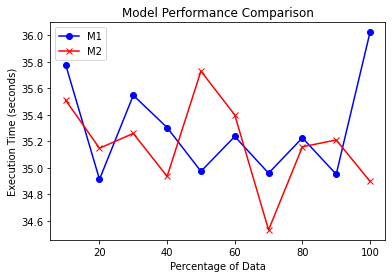

In [19]:
import matplotlib.pyplot as plt

# Define the percentages and corresponding execution times
percentages = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


# Create line plots for M1 and M2
plt.plot(percentages, execution_times_model_M1, marker='o', linestyle='-', color='b', label='M1')
plt.plot(percentages, execution_times_model_M2, marker='x', linestyle='-', color='r', label='M2')
'''plt.plot(percentages, execution_times_average, marker='o', linestyle='-', color='g', label='average_tip')
plt.plot(percentages, execution_times_total_rides, marker='x', linestyle='-', color='o', label='top_hour')'''

# Set plot labels and title
plt.xlabel("Percentage of Data")
plt.ylabel("Execution Time (seconds)")
plt.title("Model Performance Comparison")

# Add a legend
plt.legend()

# Display the plot (or save it to a PNG file)
plt.show()  # Display the plot

